In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.mixed_method_0.mixed_method_0_operators import charge_density_two_stream_mixed_method_0
from operators.legendre.legendre_operators import xi_legendre
from operators.aw_hermite.aw_hermite_operators import aw_psi_hermite
from operators.mixed_method_1.setup_mixed_method_1_two_stream import SimulationSetupMixedMethod1
from operators.poisson_solver import gmres_solver
from operators.aw_hermite.aw_hermite_operators import total_mass_aw_hermite, total_momentum_aw_hermite, total_energy_k_aw_hermite
from operators.legendre.legendre_operators import total_mass_legendre, total_momentum_legendre, total_energy_k_legendre

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
from matplotlib import colors
import matplotlib
font = {'family' : 'serif',
        'size'   : 12}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

# Enable LaTeX rendering
matplotlib.rcParams['text.usetex'] = True

In [4]:
import matplotlib.cm as cm

# Get the 'inferno' colormap
inferno_cmap = cm.get_cmap('inferno')

# Sample the colormap at three different points (e.g., 25%, 50%, 75%)
color1 = inferno_cmap(0.)
color2 = inferno_cmap(0.2)
color3 = inferno_cmap(0.4)
color4 = inferno_cmap(0.6)
color5 = inferno_cmap(0.8)
color6 = inferno_cmap(0.9)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_4750/2759109928.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  inferno_cmap = cm.get_cmap('inferno')


# Mixed method #1: advection 

In [5]:
setup = SimulationSetupMixedMethod1(Nx=101,
                                    Nv_e1=100,
                                    Nv_e2=100,
                                    epsilon=1,
                                    v_a=-5,
                                    v_b=5,
                                    alpha_e1=np.sqrt(2),
                                    u_e1=0,
                                    L=2 * np.pi,
                                    dt=1e-2,
                                    T0=0,
                                    T=20,
                                    nu_L=0,
                                    nu_H=0,
                                    n0_e1=1,
                                    n0_e2=0,
                                    alpha_e2=0,
                                    u_e2=0,
                                    gamma=0.5,
                                    alpha_tol=np.inf,
                                    u_tol=np.inf,
                                    k0=1,
                                    construct_integrals=False)

In [6]:
x = np.linspace(0, setup.L, setup.Nx+1, endpoint=True)
v = np.linspace(setup.v_a, setup.v_b, setup.Nv_int, endpoint=True)

# simulation results

In [7]:
skip = 1
# load the simulation results
# save results
sol_midpoint_u = np.load("../../data/mixed_method_1_aw_hermite_legendre/advection/sol_u_NvH_" + str(setup.Nv_e1) + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../../data/mixed_method_1_aw_hermite_legendre/advection/sol_t_NvH_" + str(setup.Nv_e1) + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

dt = 0.01 * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(20200, 2001)
(2001,)


In [8]:
runtime = np.load("../../data/mixed_method_1_aw_hermite_legendre/advection/sol_runtime_NvH_" + str(setup.Nv_e1) + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
runtime

array([910.932669  , 235.04070592])

In [9]:
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

In [10]:
# initialize the states for implicit midpoint (symplectic)
state_e_H = np.zeros((setup.Nv_e1,  setup.Nx + 1, len(sol_midpoint_t)))
state_e_L = np.zeros((setup.Nv_e2,  setup.Nx + 1, len(sol_midpoint_t)))

for ii in np.arange(0, len(sol_midpoint_t)):
    # immobile ions
    state_e_H[:, :-1, ii]  = np.reshape(sol_midpoint_u[:setup.Nv_e1*setup.Nx, ii], (setup.Nv_e1, setup.Nx)) 
    state_e_H[:, -1, ii] = state_e_H[:, 0, ii]
    # electrons species 2
    state_e_L[:, :-1, ii]  = np.reshape(sol_midpoint_u[setup.Nv_e1*setup.Nx:, ii], (setup.Nv_e2, setup.Nx))  
    state_e_L[:, -1, ii] = state_e_L[:, 0, ii]

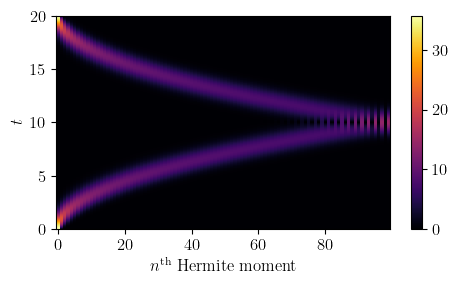

In [11]:
fig, ax = plt.subplots(figsize=(5, 3))
pos = ax.pcolormesh(np.arange(setup.Nv_e1), sol_midpoint_t, np.abs(np.fft.fft(state_e_H[:, :-1, :], axis=1)[:, 1, :]).T, cmap="inferno")
cbar = fig.colorbar(pos)
ax.set_ylabel("$t$")
ax.set_xlabel("$n^{\mathrm{th}}$ Hermite moment")
#ax.set_title("$|\hat{C}_{n}(k=1, t)|$")
plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/advection/hermite_evolution_mixed_method_1.png", dpi=600)

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_4750/3890070757.py:2: RuntimeWarning: divide by zero encountered in log10
  pos = ax.pcolormesh(np.arange(setup.Nv_e2), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_L[:, :-1, :], axis=1)[:,1, :])).T, cmap="inferno", vmin=-10, vmax=1)


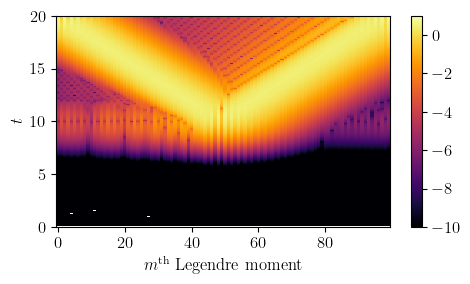

In [12]:
fig, ax = plt.subplots(figsize=(5, 3))
pos = ax.pcolormesh(np.arange(setup.Nv_e2), sol_midpoint_t, np.log10(np.abs(np.fft.fft(state_e_L[:, :-1, :], axis=1)[:,1, :])).T, cmap="inferno", vmin=-10, vmax=1)
cbar = fig.colorbar(pos)
ax.set_ylabel("$t$")
ax.set_xlabel("$m^{\mathrm{th}}$ Legendre moment")
#ax.set_title("$|\hat{B}_{m}(k=1, t)|$")
plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/advection/legendre_evolution_mixed_method_1.png", dpi=600)

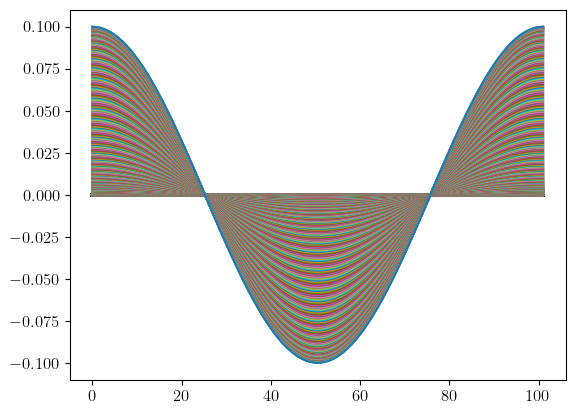

In [13]:
_ = plt.plot(state_e_L[0, :, :])

In [14]:
X, V = np.meshgrid(x, v)

In [15]:
cmap1 = plt.get_cmap('inferno_r')
cmap2 = plt.get_cmap('inferno') # Reversed

# Combine the two colormaps to create a diverging colormap
# This creates a diverging colormap from 'inferno' and 'inferno_r'
div_cmap = colors.ListedColormap(np.vstack((cmap1(np.linspace(0, 1, 128)), cmap2(np.linspace(0, 1, 128)))))


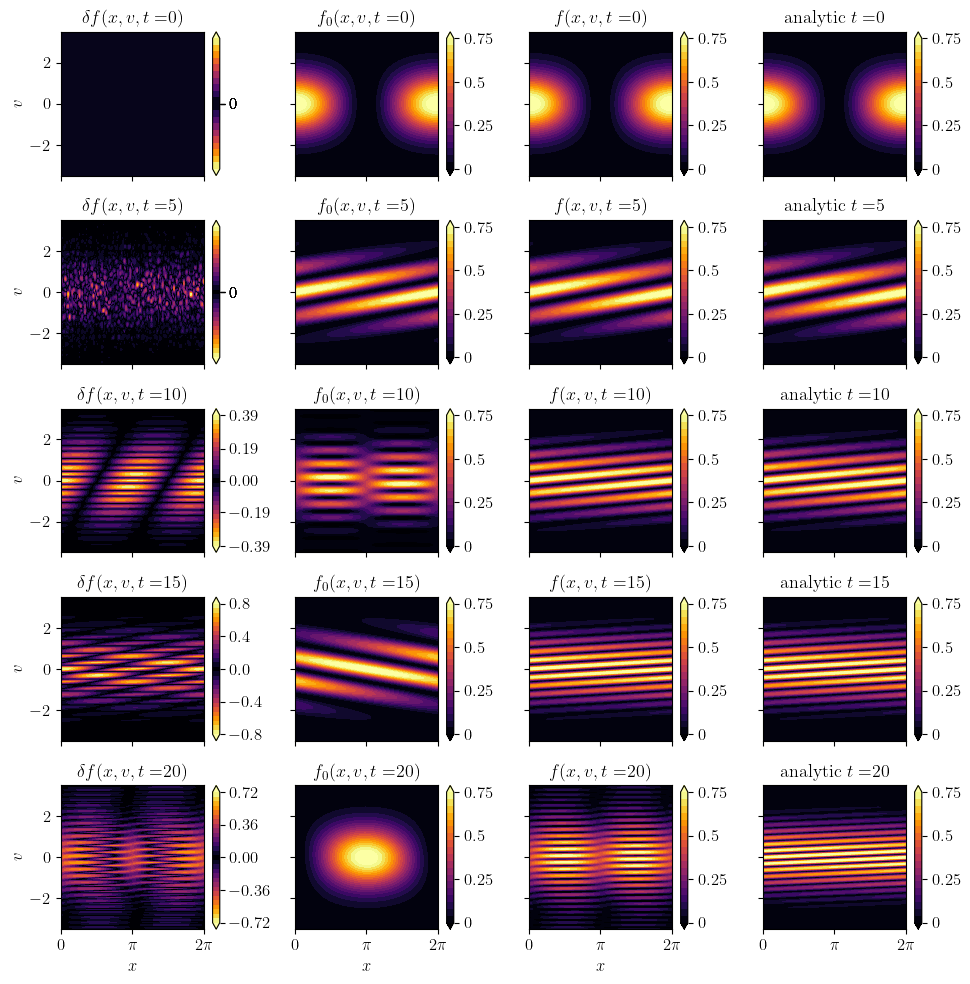

In [16]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(10, 10), sharex=True, sharey=True)

levels = np.linspace(-0.05, 0.4, 50)

for tt, ii in enumerate([0, int(1*len(sol_midpoint_t)//4), int(2*len(sol_midpoint_t)//4), int(3*len(sol_midpoint_t)//4),  -1]):
    ii = int(ii)
    distribution1 = np.zeros((len(x), len(v)))
    distribution2 = np.zeros((len(x), len(v)))
    for jj in range(setup.Nv_e1):
        distribution1 += np.outer(state_e_H[jj, :, ii], aw_psi_hermite(v=v, u_s=setup.u_e1[-1], alpha_s=setup.alpha_e1[-1], n=jj))
    for jj in range(setup.Nv_e2):
        distribution2 += np.outer(state_e_L[jj, :, ii], xi_legendre(v=v, v_b=setup.v_b, v_a=setup.v_a, n=jj))
    if tt != 0:
        pos2 = ax[tt, 0].contourf(x, v, distribution2.T, cmap=div_cmap, levels=np.linspace(-np.max(np.abs(distribution2)), np.max(np.abs(distribution2)), 30), extend="both", 
                                      vmin=-np.max(np.abs(distribution2)), vmax=np.max(np.abs(distribution2)))
    else:
        pos2 = ax[tt, 0].contourf(x, v, distribution2.T, cmap=div_cmap, levels=20, extend="both")
    pos1 = ax[tt, 1].contourf(x, v, distribution1.T, cmap="inferno", vmin=0, vmax=0.75, levels=np.linspace(0, 0.75, 20), extend="both")
    pos3 = ax[tt, 2].contourf(x, v, distribution1.T + distribution2.T, cmap="inferno", vmin=0, vmax=0.75, levels=np.linspace(0, 0.75, 20), extend="both")
    pos4 = ax[tt, 3].contourf(x, v, 1/np.sqrt(np.pi) * np.exp(-0.5 * V**2) * (1 + setup.epsilon*np.cos((X - V*sol_midpoint_t[ii]))) / setup.alpha_e1[-1],
                                cmap="inferno",  vmin=0, vmax=0.75, levels=np.linspace(0, 0.75, 20), extend="both")

    ax[tt, 0].set_ylabel(r"$v$")
    cbar = fig.colorbar(pos2, ticks=np.round(np.linspace(-np.max(np.abs(distribution2)), np.max(np.abs(distribution2)), 5), 2))
    
    cbar = fig.colorbar(pos1, ticks=[0, 0.25, 0.5, 0.75])
    cbar.ax.set_yticklabels(["0", "0.25", "0.5", "0.75"])
    cbar = fig.colorbar(pos3, ticks=[0, 0.25, 0.5, 0.75])
    cbar.ax.set_yticklabels(["0", "0.25", "0.5", "0.75"])
    cbar = fig.colorbar(pos4, ticks=[0, 0.25, 0.5, 0.75])
    cbar.ax.set_yticklabels(["0", "0.25", "0.5", "0.75"])

    ax[tt, 0].set_title('$\delta f(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", fontsize=13)
    ax[tt, 1].set_title('$f_{0}(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", fontsize=13)
    ax[tt, 2].set_title('$f(x, v, t=$' + str(int(sol_midpoint_t[ii])) + ")", fontsize=13)
    ax[tt, 3].set_title("analytic $t=$" + str(int(sol_midpoint_t[ii])), fontsize=13)
    ax[tt, 0].set_ylim(-3.5, 3.5)
    
ax[tt, 0].set_xlabel("$x$")
ax[tt, 0].set_xticks([0, np.pi, 2*np.pi])
ax[tt, 0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[tt, 2].set_xlabel("$x$")
ax[tt, 1].set_xlabel("$x$")
ax[tt, 1].set_xticks([0, np.pi, 2*np.pi])
ax[tt, 1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])

plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/advection/advection_mixed_method_1.png", dpi=600)

In [17]:
error = np.zeros(len(sol_midpoint_t))
for ii in range(len(sol_midpoint_t)):
    distribution1 = np.zeros((len(x), len(v)))
    distribution2 = np.zeros((len(x), len(v)))
    for jj in range(setup.Nv_e1):
        distribution1 += np.outer(state_e_H[jj, :, ii], aw_psi_hermite(v=v, u_s=setup.u_e1[-1], alpha_s=setup.alpha_e1[-1], n=jj))
    for idx, jj in enumerate(np.arange(setup.Nv_start, setup.Nv_e2 + setup.Nv_start)):
        distribution2 += np.outer(state_e_L[idx, :, ii], xi_legendre(v=v, v_b=setup.v_b, v_a=setup.v_a, n=jj))
    analytic = 1/np.sqrt(np.pi) * np.exp(-0.5 * V**2) * (1 + setup.epsilon*np.cos((X - V*sol_midpoint_t[ii]))) / setup.alpha_e1[-1]
    numerical = distribution1 + distribution2
    error[ii] = np.linalg.norm(numerical - analytic.T, ord=2)

AttributeError: 'SimulationSetupMixedMethod1' object has no attribute 'Nv_start'

In [ ]:
plt.plot(sol_midpoint_t, error)
plt.yscale("log")
plt.ylim(1e-2, 1e2)

In [ ]:
np.save("../../data/mixed_method_1_aw_hermite_legendre/advection/error_L2_NvH_" + str(setup.Nv_e1) + "_NvL_" + str(setup.Nv_e2) +
            "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy", error)

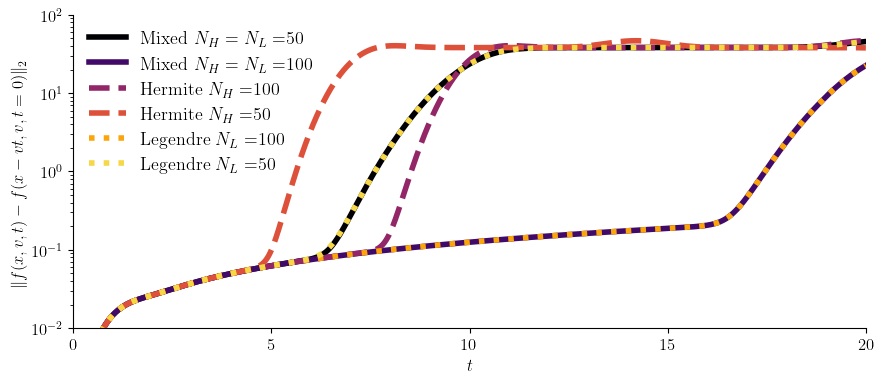

In [19]:
fig, ax = plt.subplots(figsize=(9, 4))
Nv = 100

error_mixed_method1_half = np.load("../../data/mixed_method_1_aw_hermite_legendre/advection/error_L2_NvH_" + str(Nv//2) + "_NvL_" + str(Nv//2) +
        "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

error_mixed_method1 = np.load("../../data/mixed_method_1_aw_hermite_legendre/advection/error_L2_NvH_" + str(Nv) + "_NvL_" + str(Nv) +
        "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

error_hermite = np.load("../../data/aw_hermite/advection/error_L2_Nv_" + str(Nv) + "_Nx_" + str(setup.Nx) 
                        + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

error_legendre = np.load("../../data/legendre/advection/error_L2_Nv_" + str(Nv) + "_Nx_" 
                         + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

error_hermite_half = np.load("../../data/aw_hermite/advection/error_L2_Nv_" + str(Nv//2) + "_Nx_" + str(setup.Nx) 
                        + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

error_legendre_half = np.load("../../data/legendre/advection/error_L2_Nv_" + str(Nv//2) + "_Nx_" 
                         + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")


ax.plot(sol_midpoint_t, error_mixed_method1_half, ls="-", color=color1, label=r"Mixed $N_{H}  = N_{L} = $" + str(Nv//2) , linewidth=4)
ax.plot(sol_midpoint_t, error_mixed_method1, ls="-", color=color2, label=r"Mixed $N_{H}  = N_{L} = $" + str(Nv) , linewidth=4)
ax.plot(sol_midpoint_t, error_hermite, ls="--", color=color3, label=r"Hermite $N_{H} =$" + str(Nv), linewidth=4)
ax.plot(sol_midpoint_t, error_hermite_half, ls="--", color=color4, label=r"Hermite $N_{H} =$" + str(Nv//2), linewidth=4)
ax.plot(sol_midpoint_t, error_legendre, ls=":", color=color5, label=r"Legendre $N_{L} = $" + str(Nv), linewidth=4)
ax.plot(sol_midpoint_t, error_legendre_half, ls=":", color=color6, label=r"Legendre $N_{L} = $" + str(Nv//2), linewidth=4)

ax.set_xlim(0, 20)
ax.set_yscale("log")
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_ylim(1e-2, 100)
ax.set_xlabel("$t$")
ax.set_ylabel("$\|f(x, v, t) - f(x-vt, v, t=0)\|_{2}$")
legend = ax.legend(ncols=1, fontsize=13, loc="upper left")
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("../../figures/mixed_method_1/advection/error_comparison_all_DOF_Nv_" + str(Nv) + ".png", dpi=600)